## Regression of tweet count goes vrrr

In [71]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import ydata_profiling
from ydata_profiling import ProfileReport
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [56]:
df = pd.read_csv("../data/processed/grouped_date_mun_hour.csv")
#df['geometry'] = df['geometry'].apply(wkt.loads)
#df = gpd.GeoDataFrame(df).set_crs('EPSG:4326')
#df['hour_blocks'] = df['time'].str.split(':').str[0].astype(int)

In [57]:
df = df.drop(['class', 'Unnamed: 0'], axis=1)

In [58]:
df

,municipality.name,hour_category,temperature,minTemperature,maxTemperature,precipitation,wind_speed,wind_dir,curr_cell,curr_site,tweet_count,month,day,day_of_week,population,elevation
0,Andalo,A,9.200000,8.5,12.000000,0.0,NaN,NaN,0.000000,0.000000,1,11,1,4,1024,1042
1,Baselga di Pinè,B,11.533333,8.0,13.733333,0.0,0.2,236.0,5.996413,0.016458,3,11,1,4,4928,964
2,Baselga di Pinè,C,11.433333,7.3,12.966667,0.0,0.0,184.0,10.637787,0.017426,3,11,1,4,4928,964
3,Baselga di Pinè,D,9.350000,6.6,12.200000,0.0,NaN,NaN,18.809585,0.024556,2,11,1,4,4928,964
4,Bedollo,B,14.120000,8.7,14.500000,0.0,0.3,232.5,0.383955,0.015358,5,11,1,4,1476,1059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5026,Vigo di Fassa,B,-7.450000,-10.0,0.300000,0.0,NaN,NaN,0.000000,0.000000,4,12,31,1,1219,1382
5027,Vigo di Fassa,C,-3.966667,-10.0,0.300000,0.0,NaN,NaN,0.000000,0.000000,3,12,31,1,1219,1382
5028,Vigo di Fassa,D,-8.125000,-10.0,0.300000,0.0,NaN,NaN,0.000000,0.000000,4,12,31,1,1219,1382
5029,Villa Agnedo,C,0.533333,-3.3,4.900000,0.0,NaN,NaN,9.225448,0.044170,3,12,31,1,994,356


In [59]:
X = df[['month', 'day', 'day_of_week',
        'municipality.name', 
        'hour_category', 
        'temperature', 
        'minTemperature', 
        'maxTemperature', 
        'precipitation',
        'wind_speed',
        'wind_dir',
        'curr_cell',
        'curr_site',
       'population', 'elevation']]
y = df['tweet_count']

In [60]:
# Separate categorical features
categorical_features = ['day_of_week', 'municipality.name', 'hour_category']  # Any string or categorical features
numerical_features = ['temperature', 
                      'minTemperature', 
                      'maxTemperature', 
                      'precipitation', 
                      'wind_speed',
                      'wind_dir',
                      'curr_cell',
                      'curr_site', 'day', 'month', 'population', 'elevation']

In [61]:
# Encode categorical features
le = LabelEncoder()
for feat in categorical_features:
    X[feat] = le.fit_transform(X[feat])

/var/folders/96/_x5hcfwd0qd065qkfnngc6bh0000gn/T/ipykernel_37307/717494479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feat] = le.fit_transform(X[feat])
/var/folders/96/_x5hcfwd0qd065qkfnngc6bh0000gn/T/ipykernel_37307/717494479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feat] = le.fit_transform(X[feat])
/var/folders/96/_x5hcfwd0qd065qkfnngc6bh0000gn/T/ipykernel_37307/717494479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [62]:
# Scale the numerical features
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(X[numerical_features])

In [63]:
# Convert the scaled numerical features back to a DataFrame
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_features)

In [64]:
# Combine the scaled numerical features and encoded categorical features
X = pd.concat([scaled_numerical_df, X[categorical_features].astype('category')], axis=1)

In [65]:
X.dtypes
# it is possible to separate month and day from date

temperature           float64
minTemperature        float64
maxTemperature        float64
precipitation         float64
wind_speed            float64
wind_dir              float64
curr_cell             float64
curr_site             float64
day                   float64
month                 float64
population            float64
elevation             float64
day_of_week          category
municipality.name    category
hour_category        category
dtype: object

In [66]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
# Initialize and train the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [113]:
# Make predictions for the test set
y_pred = rf_regressor.predict(X_test)

In [72]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")
print(f"MSE: {mse}")

Mean Absolute Error: 3.427934458788481
R² Score: 0.5666704205265447
MSE: 64.5279971201589


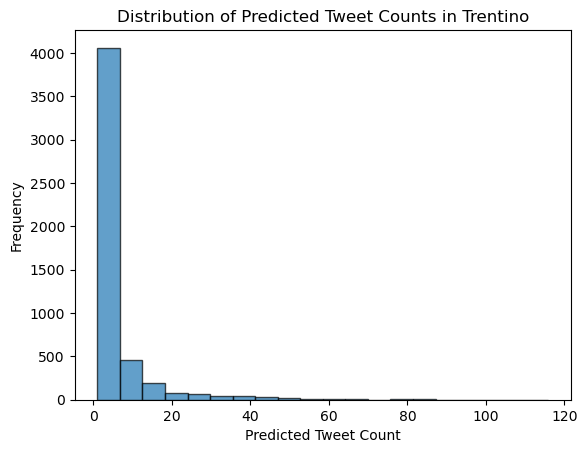

,day_of_week,municipality.name,hour_category,predicted_tweet_count,tweet_count
0,4,Andalo,A,1.60,1
1,4,Baselga di Pinè,B,2.71,3
2,4,Baselga di Pinè,C,3.08,3
3,4,Baselga di Pinè,D,1.97,2
4,4,Bedollo,B,4.69,5
...,...,...,...,...,...
5026,1,Vigo di Fassa,B,3.59,4
5027,1,Vigo di Fassa,C,3.54,3
5028,1,Vigo di Fassa,D,3.56,4
5029,1,Villa Agnedo,C,2.33,3


In [78]:
# Predict the Twitter count for all municipalities and timeslots
y_pred_full = rf_regressor.predict(X)

# Add the predictions to the original grouped data
df['predicted_tweet_count'] = y_pred_full

# Example: You can explore the distribution of tweets by plotting a histogram
import matplotlib.pyplot as plt

plt.hist(df['predicted_tweet_count'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Predicted Tweet Counts in Trentino')
plt.xlabel('Predicted Tweet Count')
plt.ylabel('Frequency')
plt.show()

# Now you can survey the distribution of predicted tweet counts in Trentino
df[['day_of_week','municipality.name', 'hour_category', 'predicted_tweet_count', 'tweet_count']]

In [94]:
#df_sorted = df.sort_values(by='tweet_count')

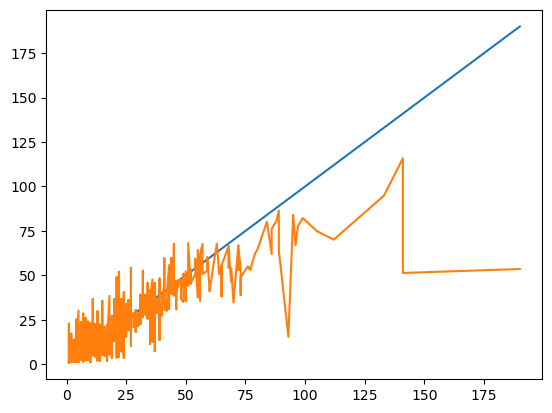

In [103]:
plt.plot(df_sorted['tweet_count'], df_sorted['tweet_count'])
plt.plot(df_sorted['tweet_count'], df_sorted['predicted_tweet_count'])

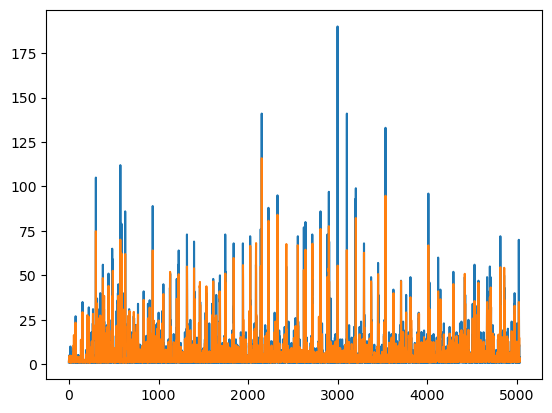

In [115]:
plt.plot(range(5031), df['tweet_count'])
plt.plot(range(5031), df['predicted_tweet_count'])

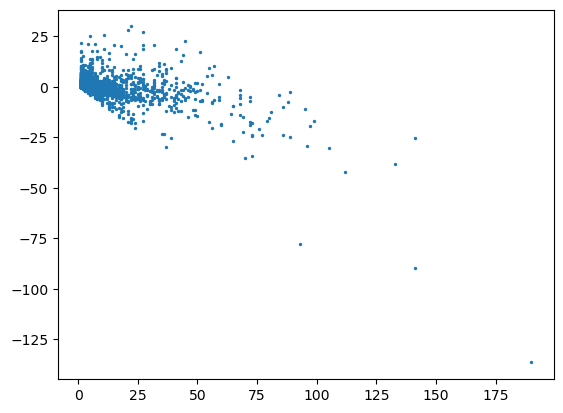

In [110]:
plt.scatter(df_sorted['tweet_count'], df_sorted['predicted_tweet_count'] - df_sorted['tweet_count'], s=2)
#plt.xscale('log')
#plt.yscale('log')

Famous peak that is difficult to predict, probabily depends on daily stuff

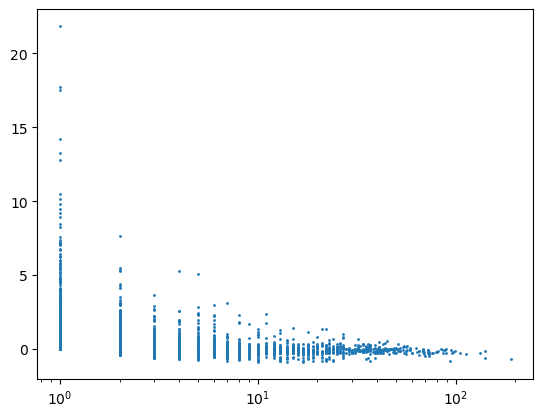

In [111]:
plt.scatter(df_sorted['tweet_count'], (df_sorted['predicted_tweet_count'] - df_sorted['tweet_count'])/df_sorted['tweet_count'],
           s=1)
plt.xscale('log')

## Peak detection

Trying to find the peak

In [90]:
df.sort_values(by='tweet_count')

,municipality.name,hour_category,temperature,minTemperature,maxTemperature,precipitation,wind_speed,wind_dir,curr_cell,curr_site,tweet_count,month,day,day_of_week,population,elevation,predicted_tweet_count
0,Andalo,A,9.200000,8.500000,12.000000,0.0,NaN,NaN,0.000000,0.000000,1,11,1,4,1024,1042,1.60
2605,Mezzocorona,D,-0.900000,-4.600000,4.600000,0.0,NaN,NaN,0.000000,0.000000,1,12,9,6,5179,219,1.22
2606,Moena,D,-4.900000,-5.700000,1.400000,0.0,NaN,NaN,0.000000,0.000000,1,12,9,6,2682,1184,1.65
2607,Pergine Valsugana,B,0.200000,-3.900000,3.700000,0.0,0.000000,341.000000,0.000000,0.000000,1,12,9,6,20470,482,1.58
2610,Pinzolo,B,-0.100000,-4.300000,3.200000,0.0,0.900000,249.000000,9.534502,0.397271,1,12,9,6,3108,770,2.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,Rovereto,A,12.266071,11.400000,14.100000,0.0,4.519643,287.446429,22.909863,0.095464,112,11,11,6,37750,204,70.10
3532,Trento,B,-0.281955,-1.708271,1.567669,0.0,0.849624,271.030075,81.035721,0.129103,133,12,19,2,114063,194,94.78
2151,Trento,C,4.641135,-0.527660,9.038298,0.0,1.460284,87.638298,71.026927,0.104205,141,12,4,5,114063,194,115.88
3101,Trento,D,2.756738,0.936170,8.464539,0.0,0.890000,167.071429,28.644687,0.072458,141,12,14,1,114063,194,51.35
